In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy==1.26.4 scikit-learn==1.4.2 shap==0.45.1 lime==0.2.0.1


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df = pd.read_csv("/content/drive/MyDrive/Project/kidney_disease.csv")
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [5]:
# 2. Convert categorical to numerical using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include='object'):
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
# 3. Separate features and target
# ✅ Select only the important numeric features for kidney disease prediction
X = df.drop('classification',axis=1)   # use your exact column names
y = df['classification']


In [7]:
# Normalize column and value formatting
df.columns = df.columns.str.strip().str.lower()

# Assuming 'ckd' maps to 0 and 'notckd' maps to 1 based on common LabelEncoder behavior
# If there was a third class (e.g., 'nan' values encoded to string 'nan'), it would likely be mapped to 2.
# Filter CKD and non-CKD patients using numerical labels directly
ckd_patients = df[df['classification'] == 0] # Assuming 'ckd' maps to 0
non_ckd_patients = df[df['classification'] == 1] # Assuming 'notckd' maps to 1

# Print counts
print("Number of CKD (disease) patients:", len(ckd_patients))
print("Number of non-CKD (non-disease) patients:", len(non_ckd_patients))

# Print their details
print("\n--- CKD Patients ---")
print(ckd_patients)

print("\n--- Non-CKD Patients ---")
print(non_ckd_patients)

Number of CKD (disease) patients: 248
Number of non-CKD (non-disease) patients: 2

--- CKD Patients ---
      id   age     bp     sg   al   su  rbc  pc  pcc  ba  ...  pcv  wc  rc  \
0      0  48.0   80.0  1.020  1.0  0.0    1   2    1   1  ...   32  72  31   
1      1   7.0   50.0  1.020  4.0  0.0    1   2    1   1  ...   26  56  46   
2      2  62.0   80.0  1.010  2.0  3.0    2   2    1   1  ...   19  70  46   
3      3  48.0   70.0  1.005  4.0  0.0    2   0    2   1  ...   20  62  18   
4      4  51.0   80.0  1.010  2.0  0.0    2   2    1   1  ...   23  68  25   
..   ...   ...    ...    ...  ...  ...  ...  ..  ...  ..  ...  ...  ..  ..   
245  245  48.0  100.0    NaN  NaN  NaN    1   1    1   1  ...    7  67   5   
246  246  48.0  110.0  1.015  3.0  0.0    0   2    2   1  ...   14  46   4   
247  247  54.0   90.0  1.025  1.0  0.0    2   0    1   1  ...   44  92  46   
248  248  59.0   70.0  1.010  1.0  3.0    0   0    1   1  ...   25   3  20   
249  249  56.0   90.0  1.010  4.0  1.0

In [8]:
# 4. Detect missing values
missing_features = X.columns[X.isnull().any()].tolist()

In [9]:
# 5. Impute missing values using feature-wise linear regression
def impute_missing_values(df):
    df_imputed = df.copy()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            known = df[df[col].notnull()]
            unknown = df[df[col].isnull()]
            if unknown.shape[0] == 0 or known.shape[0] == 0:
                continue
            y_train = known[col]
            X_train = known.drop(columns=[col])
            X_pred = unknown.drop(columns=[col])

            # Impute missing values in X_train and X_pred
            imputer = SimpleImputer(strategy='mean')
            X_train_imputed = imputer.fit_transform(X_train)
            X_pred_imputed = imputer.transform(X_pred)

            model = LinearRegression()
            model.fit(X_train_imputed, y_train)
            df_imputed.loc[unknown.index, col] = model.predict(X_pred_imputed)
    return df_imputed

X_original = X.copy() # Save the original X before imputation
X = impute_missing_values(X)

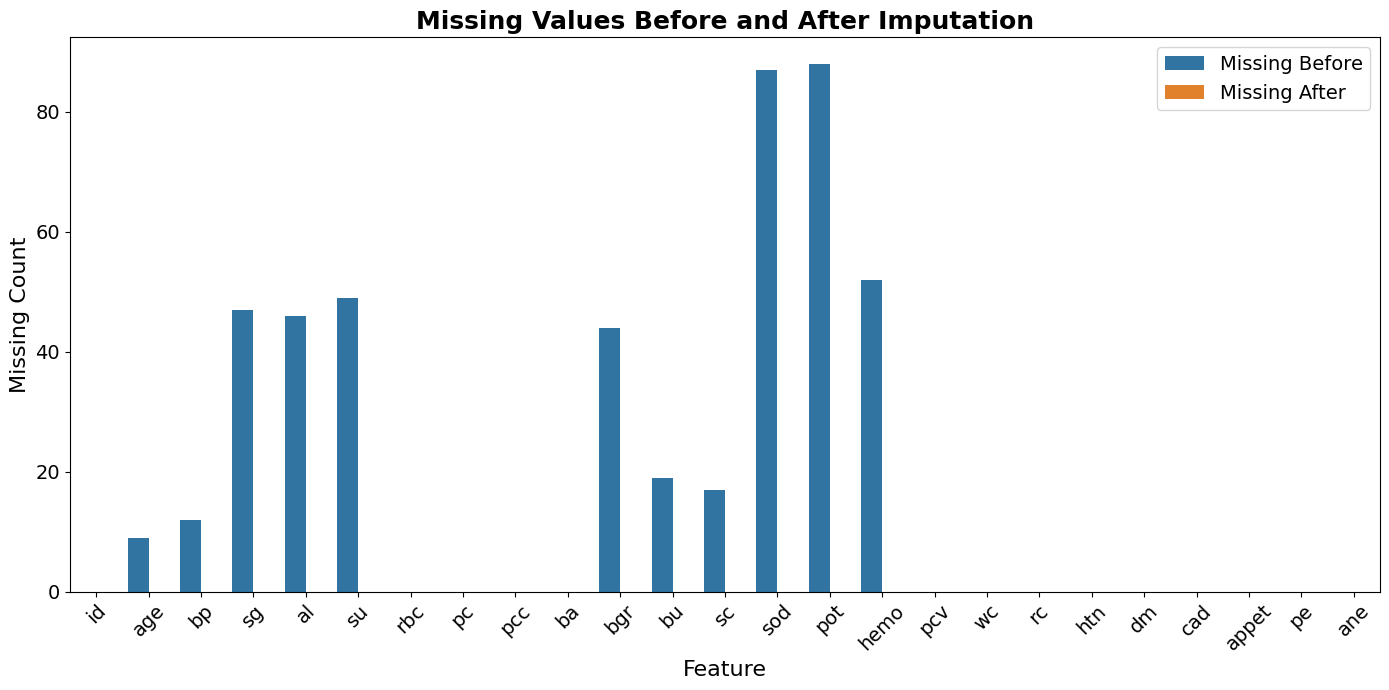

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_missing_values(df_before, df_after):
    missing_before = df_before.isnull().sum()
    missing_after = df_after.isnull().sum()

    missing_df = pd.DataFrame({
        'Feature': df_before.columns,
        'Missing Before': missing_before.values,
        'Missing After': missing_after.values
    })

    missing_df = missing_df.melt(id_vars='Feature',
                                 var_name='Stage',
                                 value_name='Missing Count')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=missing_df, x='Feature', y='Missing Count', hue='Stage')

    # Title and axis labels
    plt.title('Missing Values Before and After Imputation', fontsize=18, weight='bold')
    plt.xlabel('Feature', fontsize=16)
    plt.ylabel('Missing Count', fontsize=16)

    # Tick labels
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    # Legend
    plt.legend(fontsize=14)

    plt.tight_layout()
    plt.show()

# Call this with your before and after DataFrames
plot_missing_values(X_original, X)


In [11]:
# 6. Remove constant and quasi-constant features
selector = VarianceThreshold(threshold=0.75)
X_reduced = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support(indices=True)]
X = pd.DataFrame(X_reduced, columns=selected_columns)

In [12]:
# 7. Recursive Feature Elimination (Wrapper)
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=6)
rfe.fit(X, y)
X = X.loc[:, rfe.support_]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

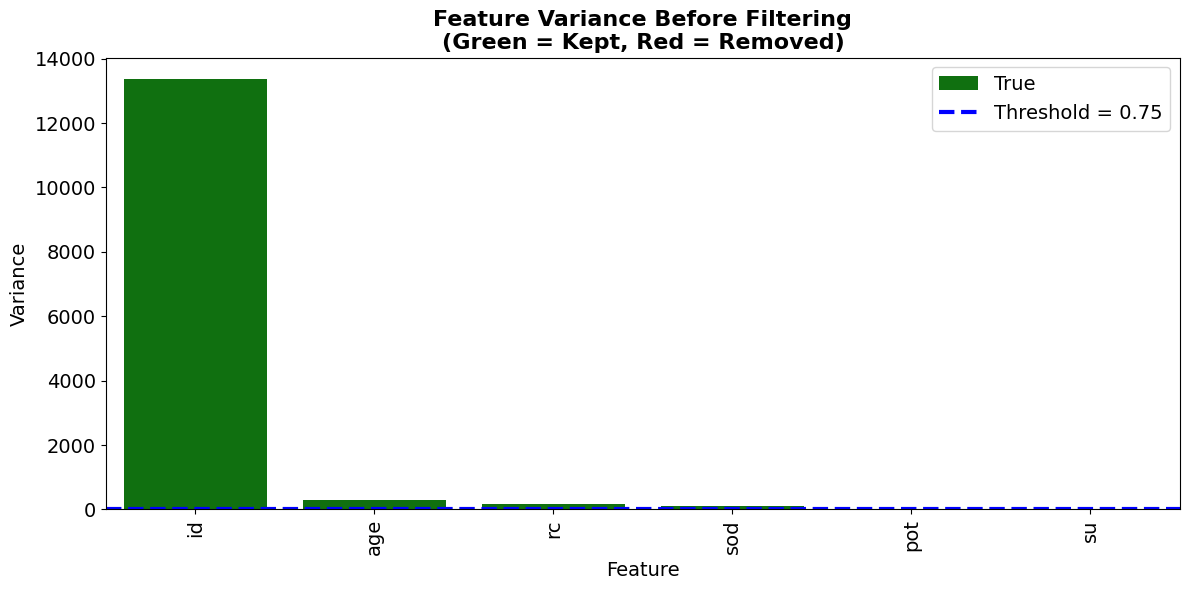

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

def plot_variance_before_after(X_before, threshold=0.75):
    # Compute variance before filtering
    variance_before = X_before.var().sort_values(ascending=False)

    # Apply VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(X_before)
    selected_columns = X_before.columns[selector.get_support(indices=True)]
    X_after = pd.DataFrame(X_reduced, columns=selected_columns)

    # Compute variance after filtering
    variance_after = X_after.var()

    # Create DataFrame for plotting
    var_df = pd.DataFrame({
        'Feature': variance_before.index,
        'Variance Before': variance_before.values,
        'Kept After Filtering': variance_before.index.isin(selected_columns)
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=var_df,
        x='Feature',
        y='Variance Before',
        hue='Kept After Filtering',
        dodge=False,
        palette={True: 'green', False: 'red'}
    )

    # Threshold line
    plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=3, label=f'Threshold = {threshold}')

    # Titles and labels
    plt.title('Feature Variance Before Filtering\n(Green = Kept, Red = Removed)', fontsize=16, weight='bold')
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Variance', fontsize=14)

    # Tick labels
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)

    # Legend
    plt.legend(fontsize=14)

    plt.tight_layout()
    plt.show()

    return X_after

# Example usage:
X_original = X.copy()  # Before filtering
X = plot_variance_before_after(X_original, threshold=0.75)


In [ ]:
# 8. Balance dataset using SMOTE
# Check the class distribution
class_counts = y.value_counts()
min_class_size = class_counts.min()

if min_class_size >= 2:
    # Set n_neighbors to the minimum required if the minority class size is between 2 and 5
    n_neighbors = min(5, min_class_size -1) if min_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_bal, y_bal = smote.fit_resample(X, y)
else:
    print(f"Skipping SMOTE as the minority class has only {min_class_size} sample(s).")
    X_bal = X
    y_bal = y

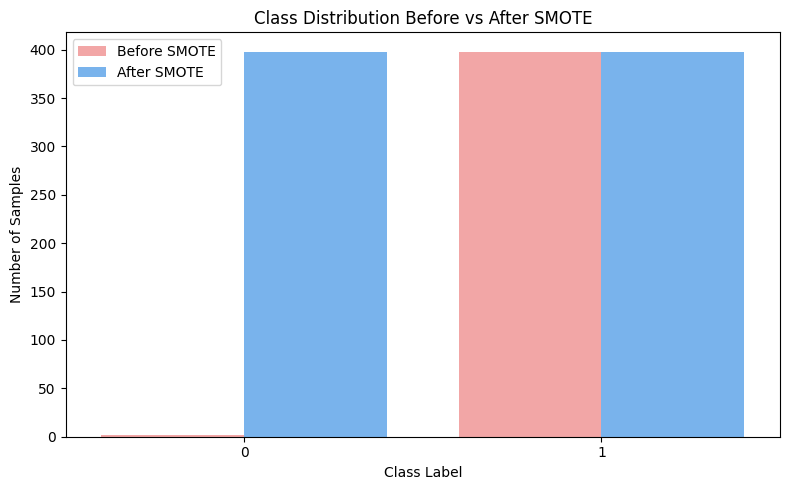

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Example: assume X and y are already defined

class_counts = y.value_counts()
min_class_size = class_counts.min()

if min_class_size >= 2:
    n_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_bal, y_bal = smote.fit_resample(X, y)
else:
    print(f"Skipping SMOTE as the minority class has only {min_class_size} sample(s).")
    X_bal, y_bal = X, y

# Plotting before vs after balancing
def plot_class_distribution(y_before, y_after):
    df_before = y_before.value_counts().reset_index()
    df_before.columns = ['class', 'count']
    df_before['stage'] = 'Before SMOTE'

    df_after = y_after.value_counts().reset_index()
    df_after.columns = ['class', 'count']
    df_after['stage'] = 'After SMOTE'

    df_combined = pd.concat([df_before, df_after], ignore_index=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_combined,
        x='class',
        y='count',
        hue='stage',
        palette=['#FF9999', '#66B3FF']
    )
    plt.title('Class Distribution Before vs After SMOTE')
    plt.ylabel('Number of Samples')
    plt.xlabel('Class Label')
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

# Call plotting function
plot_class_distribution(y, y_bal)


In [ ]:
# 9. Prepare Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(X_bal, y_bal)):
    print(f"Fold {fold+1}: Train size = {len(train_index)}, Test size = {len(test_index)}")

Fold 1: Train size = 716, Test size = 80
Fold 2: Train size = 716, Test size = 80
Fold 3: Train size = 716, Test size = 80
Fold 4: Train size = 716, Test size = 80
Fold 5: Train size = 716, Test size = 80
Fold 6: Train size = 716, Test size = 80
Fold 7: Train size = 717, Test size = 79
Fold 8: Train size = 717, Test size = 79
Fold 9: Train size = 717, Test size = 79
Fold 10: Train size = 717, Test size = 79


In [ ]:
# Final dataset
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,1,2,1,1,...,32,72,31,2,5,2,0,1,1,1
1,1,7.0,50.0,1.020,4.0,0.0,1,2,1,1,...,26,56,46,1,4,2,0,1,1,1
2,2,62.0,80.0,1.010,2.0,3.0,2,2,1,1,...,19,70,46,1,5,2,2,1,2,1
3,3,48.0,70.0,1.005,4.0,0.0,2,0,2,1,...,20,62,18,2,4,2,2,2,2,1
4,4,51.0,80.0,1.010,2.0,0.0,2,2,1,1,...,23,68,25,1,4,2,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,2,2,1,1,...,35,62,28,1,4,2,0,1,1,1
396,396,42.0,70.0,1.025,0.0,0.0,2,2,1,1,...,42,72,41,1,4,2,0,1,1,1
397,397,12.0,80.0,1.020,0.0,0.0,2,2,1,1,...,37,61,33,1,4,2,0,1,1,1
398,398,17.0,60.0,1.025,0.0,0.0,2,2,1,1,...,39,67,38,1,4,2,0,1,1,1


In [ ]:
pip install lime shap


In [ ]:
import lime
import lime.lime_tabular
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split data (ensure X_bal and y_bal are defined from previous steps)
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Train a Random Forest model as an example (as rf_model is used in predict_fn)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Initialize the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.astype(str),
    class_names=[str(c) for c in np.unique(y_train)],
    mode='classification'
)

# Pick an instance to explain
i = 0  # index of sample
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=rf_model.predict_proba
)

# Show explanation
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [ ]:
pip install shap



Explaining instance 0...


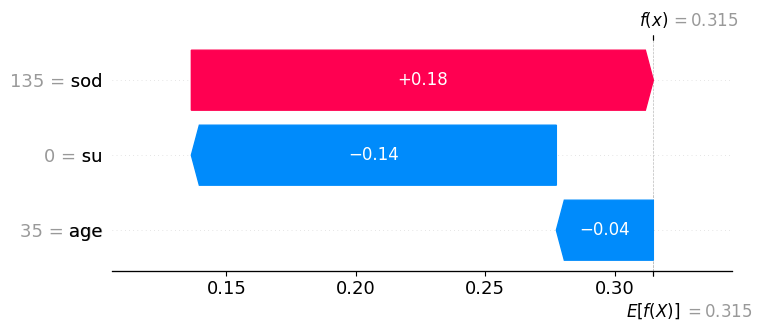

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Step 1: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Step 2: Train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: SHAP Explainer
explainer = shap.Explainer(rf_model, X_train)

# Step 4: Compute SHAP values
shap_values = explainer(X_test)

# Step 5: Determine if binary or multiclass
num_classes = len(np.unique(y_train))
instance_index = 0
print(f"\nExplaining instance {instance_index}...")

# Step 6: Plot Waterfall
if num_classes == 2:
    # Binary case – works directly
    shap.plots.waterfall(shap_values[instance_index])
else:
    # Multiclass case – must manually index class and build explanation
    class_index = 0  # You can change to 1, 2, etc. for other classes

    # Build a single SHAP explanation for the selected instance and class
    single_expl = shap.Explanation(
        values=shap_values.values[instance_index, class_index],
        base_values=shap_values.base_values[instance_index, class_index],
        data=shap_values.data[instance_index],
        feature_names=shap_values.feature_names
    )
    shap.plots.waterfall(single_expl)



### Logistic Regression

In [ ]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

#  Initialize and train logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

#  Make predictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]  # For ROC-AUC

#  Evaluate performance
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC:", round(roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr'), 4))

#  Confusion Matrix
print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.41      0.51        49
           1       0.80      0.98      0.88        50
           2       0.68      0.80      0.73        50

    accuracy                           0.73       149
   macro avg       0.72      0.73      0.71       149
weighted avg       0.72      0.73      0.71       149

Accuracy: 0.7315
 ROC-AUC: 0.8699
 Confusion Matrix:
[[20 10 19]
 [ 1 49  0]
 [ 8  2 40]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### LR(k-fold)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.41      0.51        49
           1       0.80      0.98      0.88        50
           2       0.68      0.80      0.73        50

    accuracy                           0.73       149
   macro avg       0.72      0.73      0.71       149
weighted avg       0.72      0.73      0.71       149

Accuracy: 0.7315
ROC-AUC: 0.8699


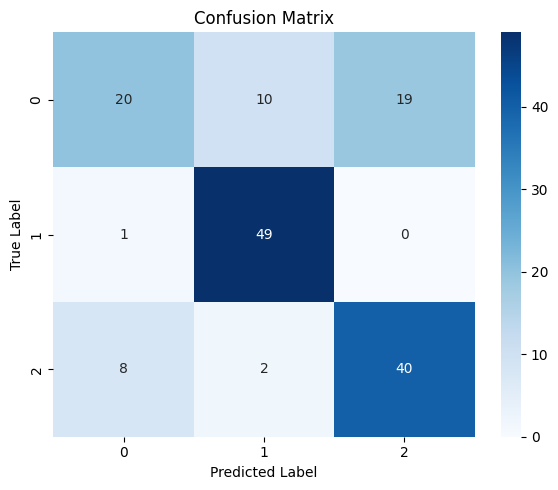


10-Fold CV Training Accuracy: 0.7359
Test Accuracy: 0.7315


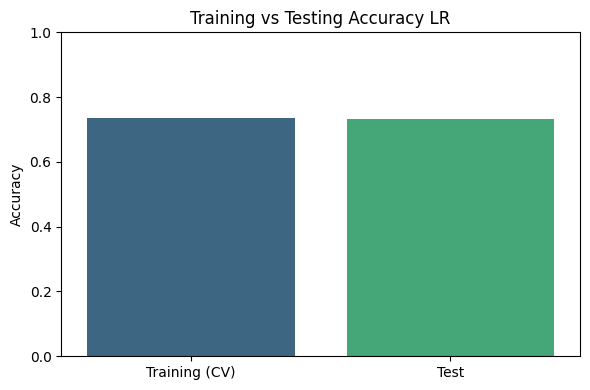

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

# Optional: ignore warnings
warnings.filterwarnings("ignore")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predictions on test set
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# --- Evaluation Metrics ---
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

# Handle binary vs multi-class for ROC-AUC
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr')
else:
    roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", round(roc_auc, 4))

# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- 10-Fold Cross-Validation (Training Accuracy) ---
cv_scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
train_acc = np.mean(cv_scores)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n10-Fold CV Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# --- Plot Training vs Test Accuracy ---
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette="viridis")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Training vs Testing Accuracy LR")
plt.tight_layout()
plt.show()


### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# SVM with linear kernel and probability output enabled
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict labels and probabilities
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test) # For ROC-AUC with multi_class

# Performance metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC:", round(roc_auc_score(y_test, y_prob, multi_class='ovr'), 4))

#  Confusion Matrix
print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

### SVM(k-fold)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        49
           1       0.91      1.00      0.95        50
           2       1.00      1.00      1.00        50

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149

Accuracy: 0.9664
ROC-AUC: 0.9747


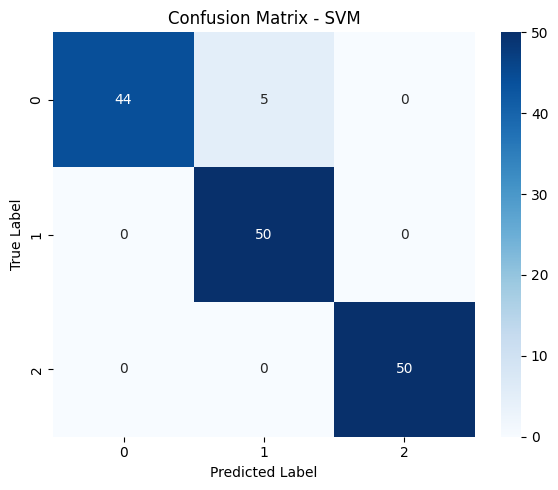

10-Fold CV Training Accuracy: 0.9295
Test Accuracy: 0.9664


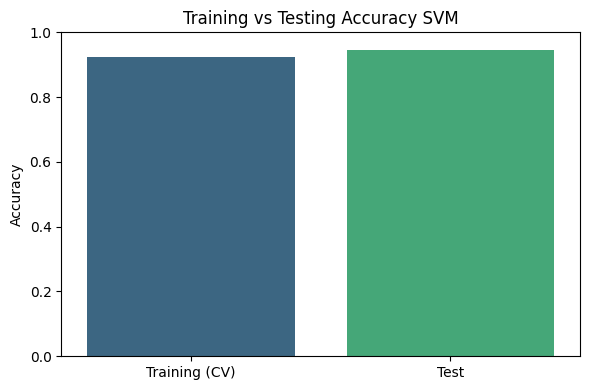

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Step 2: Initialize and train SVM (linear kernel)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Step 3: Predictions
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)  # Needed for ROC-AUC

# Step 4: Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(test_accuracy, 4))

# ROC-AUC (binary or multiclass)
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
else:
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])
print("ROC-AUC:", round(roc_auc, 4))

# Step 5: Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Step 6: Cross-Validation Accuracy (10-Fold)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='accuracy')
train_accuracy = np.mean(cv_scores)
print(f"10-Fold CV Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- Plot Training vs Test Accuracy ---
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette="viridis")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Training vs Testing Accuracy SVM")
plt.tight_layout()
plt.show()


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Define and train the model
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees
    max_depth=None,       # Let trees expand fully
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test) # For ROC-AUC

# Display classification metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC:", round(roc_auc_score(y_test, y_prob, multi_class='ovr'), 4))

# Confusion matrix
print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      0.98      0.99        50
           2       1.00      1.00      1.00        50

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149

 Accuracy: 0.9933
 ROC-AUC: 0.9936
 Confusion Matrix:
[[49  0  0]
 [ 1 49  0]
 [ 0  0 50]]


### Random forest(k-fold)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        49
           1       0.96      0.98      0.97        50
           2       0.98      0.92      0.95        50

    accuracy                           0.95       149
   macro avg       0.95      0.95      0.95       149
weighted avg       0.95      0.95      0.95       149

Accuracy: 0.953
ROC-AUC: 0.9862


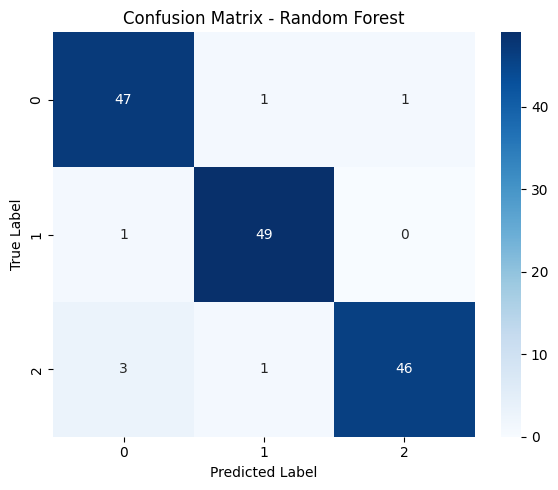

10-Fold CV Training Accuracy: 0.9580
Test Accuracy: 0.9530


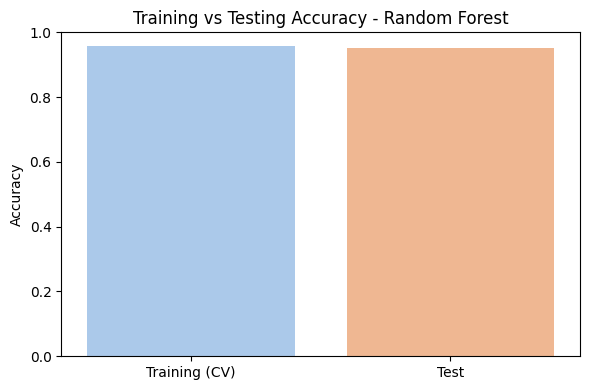

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# 2. Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 3. Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

# 4. Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

test_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(test_acc, 4))

# Multiclass or binary ROC-AUC
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
else:
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])
print("ROC-AUC:", round(roc_auc, 4))

# 5. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 6. 10-Fold Cross-Validation Accuracy
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='accuracy')
train_acc = np.mean(cv_scores)
print(f"10-Fold CV Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# 7. Bar Graph: Training vs Test Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette='pastel')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
print(X_train.columns)

Index(['age', 'su', 'sod', 'pot', 'rc'], dtype='object')


In [ ]:
print(np.unique(y_bal))

[0 1 2]


In [ ]:
print(pd.Series(y_bal).value_counts())

0    248
1    248
2    248
Name: count, dtype: int64


In [ ]:
# ===============================
# 💾 Save and Download Model
# ===============================
import joblib
from google.colab import files

# Save the trained Random Forest model
joblib.dump(rf_model, 'model.pkl')
print("✅ Model saved successfully as model.pkl")

# Download it to your computer
files.download('model.pkl')


✅ Model saved successfully as model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Gaussian Naive Bayes (used for continuous features)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)  # For ROC-AUC

# Evaluation metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC:", round(roc_auc_score(y_test, y_prob, multi_class='ovr'), 4))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92        49
           1       1.00      1.00      1.00        50
           2       0.89      0.98      0.93        50

    accuracy                           0.95       149
   macro avg       0.96      0.95      0.95       149
weighted avg       0.96      0.95      0.95       149

 Accuracy: 0.953
 ROC-AUC: 0.998
 Confusion Matrix:
[[43  0  6]
 [ 0 50  0]
 [ 1  0 49]]


### Navie baye's(k-fold)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92        49
           1       1.00      1.00      1.00        50
           2       0.89      0.98      0.93        50

    accuracy                           0.95       149
   macro avg       0.96      0.95      0.95       149
weighted avg       0.96      0.95      0.95       149

Accuracy: 0.953
ROC-AUC: 0.998


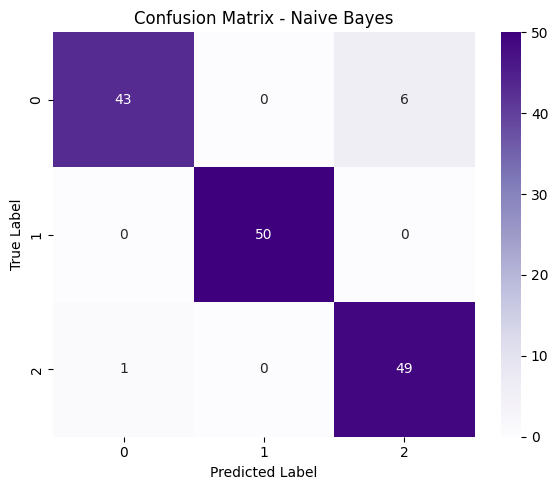

10-Fold CV Training Accuracy: 0.9294
Test Accuracy: 0.9530


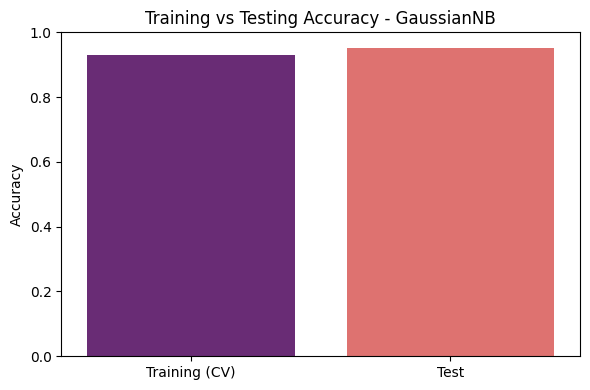

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Step 2: Train Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Step 3: Predict
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)

# Step 4: Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

test_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(test_acc, 4))

# ROC-AUC
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
else:
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])
print("ROC-AUC:", round(roc_auc, 4))

# Step 5: Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Step 6: Cross-Validation Accuracy (10-Fold)
cv_scores = cross_val_score(nb_model, X_train, y_train, cv=10, scoring='accuracy')
train_acc = np.mean(cv_scores)
print(f"10-Fold CV Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Step 7: Training vs Testing Accuracy Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette="magma")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy - GaussianNB")
plt.tight_layout()
plt.show()


### KNN

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Assuming X_bal and y_bal are your balanced features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Initialize KNN classifier with k=3 (you can change k as needed)
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)


if len(np.unique(y_bal)) == 2:
    y_prob = knn_model.predict_proba(X_test)[:, 1]
    roc_auc = round(roc_auc_score(y_test, y_prob), 4)
else:
    roc_auc = "ROC-AUC not applicable for multiclass"

# Evaluation metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC:", roc_auc)

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        49
           1       0.93      1.00      0.96        50
           2       0.98      1.00      0.99        50

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149

 Accuracy: 0.9664
 ROC-AUC: ROC-AUC not applicable for multiclass
 Confusion Matrix:
[[44  4  1]
 [ 0 50  0]
 [ 0  0 50]]


### KNN(k-fold)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        49
           1       0.93      1.00      0.96        50
           2       0.98      1.00      0.99        50

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149

Accuracy: 0.9664
ROC-AUC: ROC-AUC not applicable for multiclass


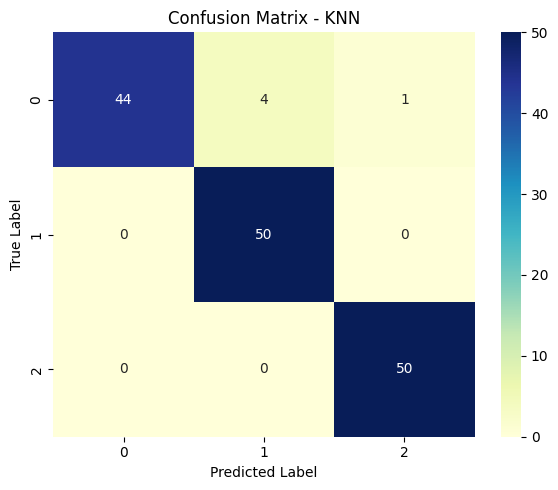

10-Fold CV Training Accuracy: 0.9563
Test Accuracy: 0.9664


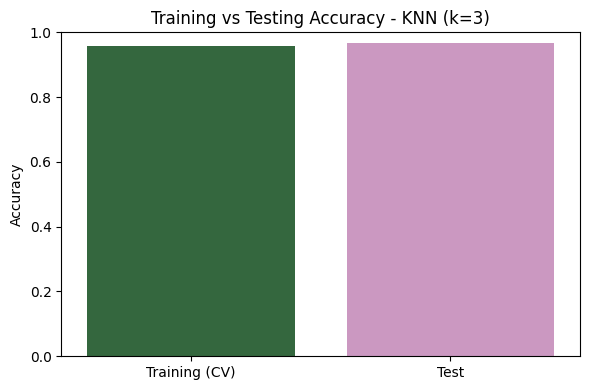

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Step 2: KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Step 3: Predictions
y_pred = knn_model.predict(X_test)

# Step 4: ROC-AUC
if len(np.unique(y_bal)) == 2:
    y_prob = knn_model.predict_proba(X_test)[:, 1]
    roc_auc = round(roc_auc_score(y_test, y_prob), 4)
else:
    roc_auc = "ROC-AUC not applicable for multiclass"

# Step 5: Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

test_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(test_acc, 4))
print("ROC-AUC:", roc_auc)

# Step 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Step 7: 10-Fold Cross-Validation Accuracy
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy')
train_acc = np.mean(cv_scores)
print(f"10-Fold CV Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Step 8: Training vs Test Accuracy Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette="cubehelix")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy - KNN (k=3)")
plt.tight_layout()
plt.show()


### XGBoost

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Assuming X_bal and y_bal are your features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# For ROC-AUC: works for binary classification only
if len(np.unique(y_bal)) == 2:
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    roc_auc = round(roc_auc_score(y_test, y_prob), 4)
else:
    roc_auc = "ROC-AUC not applicable for multiclass"

# Evaluation metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC:", roc_auc)

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.98      0.99        50
           2       1.00      0.96      0.98        50

    accuracy                           0.98       149
   macro avg       0.98      0.98      0.98       149
weighted avg       0.98      0.98      0.98       149

 Accuracy: 0.9799
 ROC-AUC: ROC-AUC not applicable for multiclass
 Confusion Matrix:
[[49  0  0]
 [ 1 49  0]
 [ 2  0 48]]


### XGBoost(k-fold)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.98      0.99        50
           2       1.00      0.96      0.98        50

    accuracy                           0.98       149
   macro avg       0.98      0.98      0.98       149
weighted avg       0.98      0.98      0.98       149

Accuracy: 0.9799
ROC-AUC: ROC-AUC not applicable for multiclass


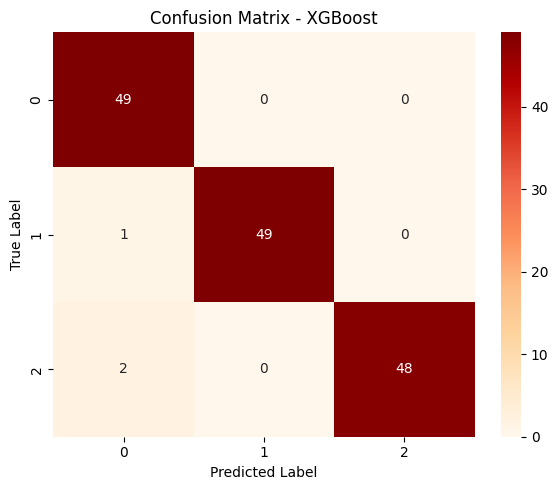

10-Fold CV Training Accuracy: 0.9949
Test Accuracy: 0.9799


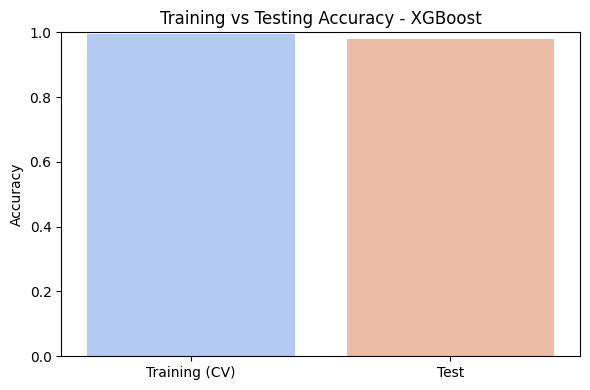

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Step 2: Train XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Step 3: Predictions
y_pred = xgb_model.predict(X_test)

# Step 4: ROC-AUC
if len(np.unique(y_bal)) == 2:
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    roc_auc = round(roc_auc_score(y_test, y_prob), 4)
else:
    roc_auc = "ROC-AUC not applicable for multiclass"

# Step 5: Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

test_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(test_acc, 4))
print("ROC-AUC:", roc_auc)

# Step 6: Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Step 7: 10-Fold Cross-Validation Accuracy
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='accuracy')
train_acc = np.mean(cv_scores)
print(f"10-Fold CV Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Step 8: Training vs Testing Accuracy Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette="coolwarm")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy - XGBoost")
plt.tight_layout()
plt.show()


### ANN

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Assuming X_bal and y_bal are your features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# For multiclass classification, convert labels to one-hot encoding
num_classes = len(np.unique(y_bal))
if num_classes > 2:
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
else:
    y_train_cat = y_train
    y_test_cat = y_test

# Build a simple ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))

if num_classes > 2:
    model.add(Dense(num_classes, activation='softmax'))  # multiclass output
    loss_function = 'categorical_crossentropy'
else:
    model.add(Dense(1, activation='sigmoid'))  # binary output
    loss_function = 'binary_crossentropy'

model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_cat, epochs=50, batch_size=16, verbose=0)

# Predict classes
if num_classes > 2:
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
else:
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob > 0.5).astype(int)

# Evaluation metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))

# ROC-AUC only for binary classification
if num_classes == 2:
    print(" ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
else:
    print(" ROC-AUC: Not applicable for multiclass")

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        49
           1       0.93      1.00      0.96        50
           2       0.98      1.00      0.99        50

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149

 Accuracy: 0.9664
 ROC-AUC: Not applicable for multiclass
 Confusion Matrix:
[[44  4  1]
 [ 0 50  0]
 [ 0  0 50]]


### ANN(k-fold)

In [ ]:
!pip install -U scikeras

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier # Not using KerasClassifier directly for cross-validation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical # Import to_categorical

# -----------------------
# Step 1: Train-Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

num_classes = len(np.unique(y_bal))
input_dim = X_train.shape[1]

# -----------------------
# Step 2: Model Builder
# -----------------------
def build_ann_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    if num_classes > 2:
        model.add(Dense(num_classes, activation='softmax'))
        loss_function = 'categorical_crossentropy'  # Change to categorical_crossentropy
    else:
        model.add(Dense(1, activation='sigmoid'))
        loss_function = 'binary_crossentropy'

    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['accuracy'])
    return model

# -----------------------
# Step 3: Manual Cross-validation
# -----------------------
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_scores = []

# Convert y_train to categorical for cross-validation training if multiclass
if num_classes > 2:
    y_train_cat_cv = to_categorical(y_train, num_classes=num_classes)
else:
    y_train_cat_cv = y_train

for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    # Split data for the current fold using positional indexing
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]

    # Use appropriate y for training (categorical for multiclass, original for binary)
    if num_classes > 2:
        y_train_fold, y_val_fold = y_train_cat_cv[train_index], y_train.iloc[val_index]
    else:
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]


    # Build and train model for the current fold
    model_fold = build_ann_model(input_dim, num_classes)
    model_fold.fit(X_train_fold, y_train_fold, epochs=50, batch_size=16, verbose=0)

    # Evaluate on validation set
    if num_classes > 2:
        y_val_pred_prob = model_fold.predict(X_val_fold)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)
    else:
        y_val_pred_prob = model_fold.predict(X_val_fold).ravel()
        y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    train_scores.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")


train_acc = np.mean(train_scores)

# -----------------------
# Step 4: Final Model Training on Full Train Set
# -----------------------
final_model = build_ann_model(input_dim, num_classes)

# Convert y_train to categorical for final model training if multiclass
if num_classes > 2:
    y_train_cat_final = to_categorical(y_train, num_classes=num_classes)
else:
    y_train_cat_final = y_train

final_model.fit(X_train, y_train_cat_final, epochs=50, batch_size=16, verbose=0)

# -----------------------
# Step 5: Prediction & Evaluation on Test Set
# -----------------------
if num_classes > 2:
    y_prob = final_model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
else:
    y_prob = final_model.predict(X_test).ravel()
    y_pred = (y_prob > 0.5).astype(int)

# Metrics
test_acc = accuracy_score(y_test, y_pred)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("Train Accuracy (10-fold CV):", round(train_acc, 4))
print("Test Accuracy:", round(test_acc, 4))

# ROC-AUC
if num_classes == 2:
    # For binary classification, y_prob is already the probability of the positive class
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
else:
    try:
        # For multiclass, use y_prob which is the output of softmax
        roc_auc = round(roc_auc_score(y_test, y_prob, multi_class='ovr'), 4)
        print("ROC-AUC (OvR):", roc_auc)
    except ValueError:
        print("ROC-AUC: Not applicable for this multiclass scenario")


# -----------------------
# Step 6: Confusion Matrix
# -----------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - ANN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# -----------------------
# Step 7: Accuracy Bar Plot
# -----------------------
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training (CV)", "Test"], y=[train_acc, test_acc], palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy - ANN")
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 1 Accuracy: 0.9667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Fold 2 Accuracy: 0.9667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 3 Accuracy: 0.9500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold 4 Accuracy: 0.9833
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 5 Accuracy: 0.9333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 6 Accuracy: 0.9661
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Fold 7 Accuracy: 0.8983
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 8 Accuracy: 0.8814


In [ ]:
# Collect all test accuracies from each model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

model_names = [
    'Logistic Regression',
    'SVM',
    'Random Forest',
    'Naive Bayes',
    'KNN',
    'XGBoost',
    'ANN'
]

test_accuracies = [
    accuracy_score(y_test, logreg.predict(X_test)),        # Logistic Regression
    accuracy_score(y_test, svm_model.predict(X_test)),     # SVM
    accuracy_score(y_test, rf_model.predict(X_test)),      # Random Forest
    accuracy_score(y_test, nb_model.predict(X_test)),      # Naive Bayes
    accuracy_score(y_test, knn_model.predict(X_test)),     # KNN
    accuracy_score(y_test, xgb_model.predict(X_test)),     # XGBoost
    test_acc                                              # ANN (already computed)
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=model_names, y=test_accuracies, palette="viridis")

# Font sizes
plt.title("Comparison of Accuracy across Models", fontsize=16, weight='bold')
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

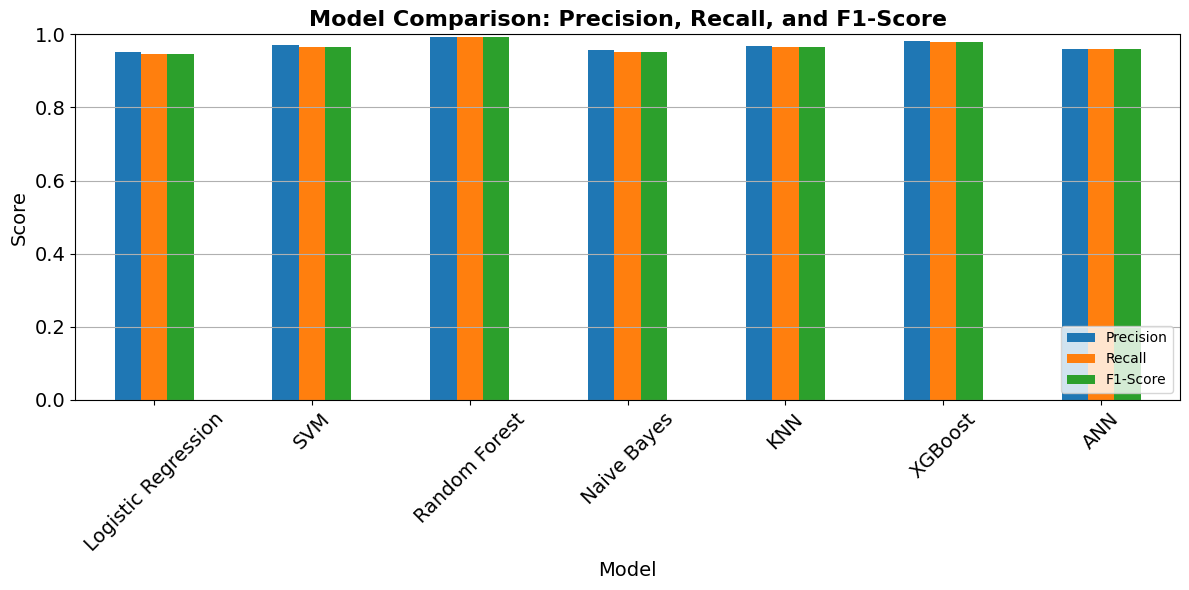

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Dictionary to store metrics
metrics = {}

# Helper function to calculate metrics for a model
def get_metrics(model_name, y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')  # change to 'macro' if needed
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    metrics[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Collect metrics from each model’s predictions (assumes you already have y_test and y_pred from each model)

# Logistic Regression
get_metrics('Logistic Regression', y_test, logreg.predict(X_test))

# SVM
get_metrics('SVM', y_test, svm_model.predict(X_test))

# Random Forest
get_metrics('Random Forest', y_test, rf_model.predict(X_test))

# Naive Bayes
get_metrics('Naive Bayes', y_test, nb_model.predict(X_test))

# KNN
get_metrics('KNN', y_test, knn_model.predict(X_test))

# XGBoost
get_metrics('XGBoost', y_test, xgb_model.predict(X_test))

# ANN (from your final model)
get_metrics('ANN', y_test, y_pred)  # y_pred from final ANN already exists
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics).T  # transpose to have models as rows

# Plotting
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison: Precision, Recall, and F1-Score",fontsize=16, weight='bold')
plt.xlabel("Model", fontsize=14)
plt.ylabel("Score",fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


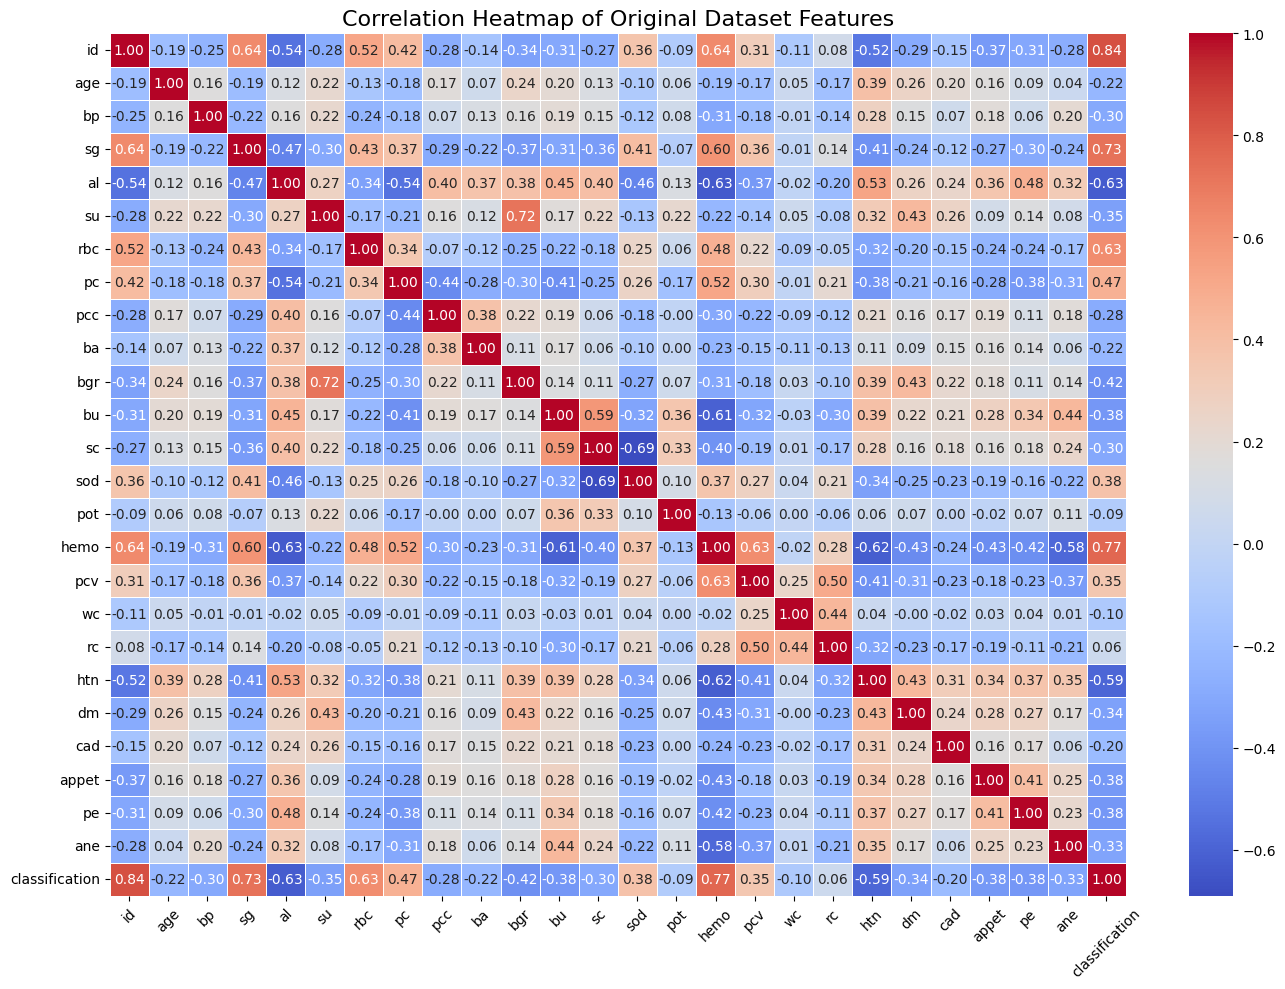

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your original dataset is stored in a DataFrame called 'df'

# Step 1: Keep only numerical columns for correlation
df_numeric = df.select_dtypes(include=['number'])

# Step 2: Compute correlation matrix
corr_matrix = df_numeric.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Original Dataset Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
